## First goal: getting a filtration from data using existing tools

[([0], 0.0),
 ([1], 0.0),
 ([2], 0.0),
 ([3], 0.0),
 ([4], 0.0),
 ([5], 0.0),
 ([6], 0.0),
 ([7], 0.0),
 ([8], 0.0),
 ([9], 0.0),
 ([1, 4], 0.17754189897452063),
 ([2, 9], 0.21634092984513148),
 ([0, 5], 0.38923828215719697),
 ([7, 8], 0.41396983569751816),
 ([0, 2], 0.4661799103760069),
 ([3, 5], 0.5023505306539154),
 ([6, 9], 0.5495225977381791),
 ([0, 9], 0.6333165887886936),
 ([0, 2, 9], 0.6333165887886936),
 ([6, 7], 0.6425919981558038),
 ([2, 6], 0.6593268580042558),
 ([2, 6, 9], 0.6593268580042558),
 ([2, 5], 0.7151393818521594),
 ([0, 2, 5], 0.7151393818521594),
 ([0, 3], 0.8914484342095101),
 ([0, 3, 5], 0.8914484342095101),
 ([5, 9], 0.9240228333721356),
 ([0, 5, 9], 0.9240228333721356),
 ([2, 5, 9], 0.9240228333721356)]

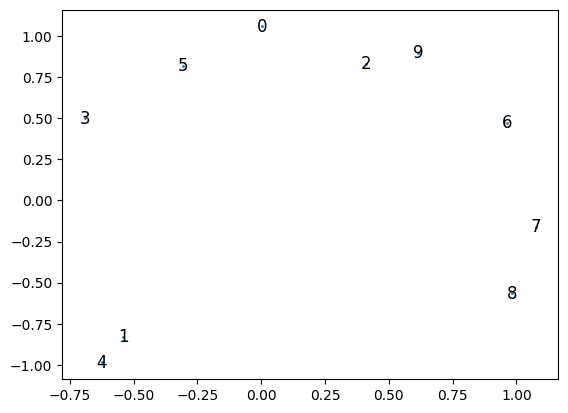

In [1]:
import numpy as np
import gudhi as gd
import tadasets
import matplotlib.pyplot as plt
sphere = tadasets.dsphere(n=10, d=1, noise=0.1)
plt.scatter(sphere[:,0], sphere[:,1], s=1)
for i, (x, y) in enumerate(sphere):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

rips = gd.RipsComplex(points=sphere, max_edge_length=1.0)
st = rips.create_simplex_tree(max_dimension=2)
st.compute_persistence()
filtration = list(st.get_filtration())

filtration

In [9]:
import numpy as np
from scipy.sparse import coo_matrix

# For now, this is slow. Probably want to move this to the Rust component, and pass the simplices directly at some point.
def compute_boundary_matrices(simplices):
    """
    Compute boundary matrices for a simplicial complex.

    Parameters:
    simplices (dict): Dictionary where keys are dimensions (int) and values are lists of tuples representing simplices.

    Returns:
    dict: Dictionary where keys are dimensions and values are NumPy arrays representing boundary matrices.
    """

    # Determine the maximum dimension
    max_dim = max(simplices.keys())

    # Create index mappings for each dimension
    index_maps = {
        dim: {simplex: idx for idx, simplex in enumerate(simplices[dim])}
        for dim in simplices
    }

    # Compute boundary matrices
    boundary_matrices = {}
    for dim in range(1, max_dim + 1):
        higher_simplices = simplices.get(dim, [])
        lower_simplices = simplices.get(dim - 1, [])
        lower_index_map = index_maps.get(dim - 1, {})

        rows = [] 
        cols = []
        data = []
        # for each of the higher simplices
        for col, simplex in enumerate(higher_simplices):
            # for each of the vertices of the simplex
            for i, _ in enumerate(simplex):
                # get face missing this index
                face = simplex[:i] + simplex[i+1:]
                # since this is a simplicial complex, the face is in the lower simplices
                row = lower_index_map.get(face)
                rows.append(row)
                cols.append(col)
                data.append((-1) ** i)
        
        # create sparse matrix
        n_rows = len(lower_simplices)
        n_cols = len(higher_simplices)
        boundary_matrices[dim] = {"n_rows": n_rows, "n_cols": n_cols, "data": data, "rows": rows, "cols": cols}

    return boundary_matrices

# example sanity check (triangle with point in middle)
simplices = {0: [(0,), (1, ), (2, ), (3,)], 1: [(2,3), (1,3), (1,2), (0,1), (0,2), (0,3)], 2: [(1,2,3), (0,2,3), (0,1,3)]}
bs = compute_boundary_matrices(simplices)
bs[2]

{'n_rows': 6,
 'n_cols': 3,
 'data': [1, -1, 1, 1, -1, 1, 1, -1, 1],
 'rows': [0, 1, 2, 0, 5, 4, 1, 5, 3],
 'cols': [0, 0, 0, 1, 1, 1, 2, 2, 2]}

In [7]:
from collections import defaultdict
# 1. Create the global boundary map
simplices_by_dim = defaultdict(list)
simplices_by_dim_only_filt = defaultdict(list)
for (simplex, filt_value) in filtration:
    dim = len(simplex) - 1
    simplices_by_dim[dim].append(tuple(sorted(simplex)))
    simplices_by_dim_only_filt[dim].append(filt_value)
b = compute_boundary_matrices(simplices_by_dim)

In [8]:
import bisect
def max_index(lst, b):
    # Find the insertion point for b to the right
    idx = bisect.bisect_right(lst, b)
    return idx 
unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
print(simplices_by_dim_only_filt)
# For each filtration value, get indices for the boundary map at that filtration value
boundary_maps_index_dict = {filt_index: 
                                {  
                                    key : max_index(filt_values, filt_value)
                                    for key, filt_values in simplices_by_dim_only_filt.items()
                                } 
                                for (filt_index, filt_value) in enumerate(unique_filtration_values)
                            }

print(boundary_maps_index_dict)

defaultdict(<class 'list'>, {0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.17754189897452063, 0.21634092984513148, 0.38923828215719697, 0.41396983569751816, 0.4661799103760069, 0.5023505306539154, 0.5495225977381791, 0.6333165887886936, 0.6425919981558038, 0.6593268580042558, 0.7151393818521594, 0.8914484342095101, 0.9240228333721356], 2: [0.6333165887886936, 0.6593268580042558, 0.7151393818521594, 0.8914484342095101, 0.9240228333721356, 0.9240228333721356]})
{0: {0: 10, 1: 0, 2: 0}, 1: {0: 10, 1: 1, 2: 0}, 2: {0: 10, 1: 2, 2: 0}, 3: {0: 10, 1: 3, 2: 0}, 4: {0: 10, 1: 4, 2: 0}, 5: {0: 10, 1: 5, 2: 0}, 6: {0: 10, 1: 6, 2: 0}, 7: {0: 10, 1: 7, 2: 0}, 8: {0: 10, 1: 8, 2: 1}, 9: {0: 10, 1: 9, 2: 1}, 10: {0: 10, 1: 10, 2: 2}, 11: {0: 10, 1: 11, 2: 3}, 12: {0: 10, 1: 12, 2: 4}, 13: {0: 10, 1: 13, 2: 6}}


## Second goal: implementation of the Schur's complement Persistent Laplacian solver for a filtration

Assumption: the dimension of each $C_q^{d_i}$ increases by at most one with each increase in $i$.
Then we can implement _Theorem 5.1_ from Memoli.

In [ ]:
import numpy as np
import persistent_laplacians
boundary_matrices = compute_boundary_matrices(simplices_by_dim)
result = persistent_laplacians.process_tda(
    boundary_matrices,
    boundary_maps_index_dict
)
print("Rust returned:", result)

Rust returned: [150, 150]


## Third goal: Eigenvalue computations